In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import rcParams
import scipy.constants as sc
import pandas as pd
import numba
from astropy.io import fits
from IPython.display import clear_output
import time
rcParams["figure.figsize"] = (5,2)

### Attempt to parallelize the process... but njit does not like it

In [41]:
@numba.njit
def vel_gen(St0, u0, v0, dz, z_list, a):
    f_loc = v0**2/2
    f_list = [f_loc]
    u = u0 *  np.exp( 1/a * (1 - ( 1 + a*z_list**2 )**(-0.5) ) )
    
    for i in range(1, len(z_list)):
        v_loc = (2*f_loc)**0.5
        f_loc += dz * ( u0/St0 - v_loc/St0 * np.exp( -1/a * (1 - ( 1 + a*z_list[i-1]**2 )**(-0.5) ) ) - z_list[i-1] / (1 + a*z_list[i-1]**2)**(1.5))
        f_list.append(f_loc)
    
    f_list = np.array(f_list)
    v_list = ( 2*f_list )**0.5
    
    return z_list[:len(v_list)], v_list, u[:len(v_list)]

@numba.njit
def vel_loop(St0, u0, v0, a, order, max_list_size, z_start, z_end):
    dz = 10**( np.log10(St0 * u0) - order )
    # list_length = 10**order / (St0 ** 2)
    list_length = (z_end - z_start) / dz
    # print('List length:', list_length)
    # print('original:', 10**order / (St0 ** 2))
    iter_total = np.ceil(list_length / max_list_size)
    # print('Step size:', dz)
    # print('Number of potential iterations:', iter_total)
#     print('List length:', f'{list_length:.2e}')
    
    Stb_i = u0 / St0
    
    # z_start
    z_end_0 = z_start + dz * max_list_size
    v_loc = v0

    P = len(St0)
    # all_list = np.empty((3,))
    all_list = []
    
    for j in range(P):
        z_list = []
        v_list = []
        u_list = []
        z_start_loc = z_start
        z_end_loc = z_end_0[j]
        for i in range(iter_total[j]):
            z_list_loc = np.arange(z_start_loc, z_end_loc, dz[j])
            z_list_loc, v_list_loc, u_list_loc = vel_gen(St0[j], u0[j], v_loc, dz[j], z_list_loc, a[j])
            
            z_start_loc = z_end_loc + dz[j]
            z_end_loc += dz[j] * max_list_size + dz[j]
            v_loc = v_list_loc[-1]
            
            z_list.extend(z_list_loc[::int(10*iter_total[j])])
            v_list.extend(v_list_loc[::int(10*iter_total[j])])
            u_list.extend(u_list_loc[::int(10*iter_total[j])])

            if (np.isnan(v_loc)):
                # print('Number of actual iterations:', i)
                break
        # all_list.append(np.array([z_list, v_list, u_list]))
        # all_list[j] = np.array([z_list, v_list, u_list])
        all_list = all_list + [np.array([z_list, v_list, u_list])]

    return all_list

In [29]:
# R = 10 # in au
P = 2
R = np.logspace(np.log10(50), np.log10(100), P) # in au
a = 1e-3 # cm
v0 = 0.
order = 2
max_array_size = 1e6

Omega = (np.sqrt(sc.G * 2e30) * 1.5e11**(-1.5)) * R**(-1.5)
c_s = 1.5 * R**(-0.25) # in km/s
sdot = 2e-12 * (R/10)**(-1.5) # in g/cm2/s
sd = 30 * (1/R) # in g/cm2
rhos = 3.5 # in g/cm3

H_R = c_s / Omega / (1.5e8) / R
eta = H_R**2
St0 = np.sqrt(2*np.pi)* a * rhos / sd
u0 = np.sqrt(2*np.pi) / Omega * sdot / sd

Stb = St0 / u0
H_c_s = 5e6 / (3600*24*365) * R**1.5 # in yr

print('eta:', eta)
print('St_0:', St0)
print('St_b:', Stb)
print('u0:', u0)
print('max_z:', 1/Stb)
print('T:', H_c_s)

# print('Array size:', f'{10**order / (St0**2):.2e}')
print('No iterations:', np.ceil(10**order / (St0**2) / max_array_size))

eta: [0.01787817 0.02528355]
St_0: [0.014622 0.029244]
St_b: [11.0057342 11.0057342]
u0: [0.00132858 0.00265716]
max_z: [0.09086173 0.09086173]
T: [ 56.05552235 158.54895992]
No iterations: [1. 1.]


In [42]:
test = vel_loop(St0, u0, v0, eta, order, max_array_size, 0, 10)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Cannot infer the type of variable 'all_list', have imprecise type: list(undefined)<iv=None>. 

For Numba to be able to compile a list, the list must have a known and
precise type that can be inferred from the other variables. Whilst sometimes
the type of empty lists can be inferred, this is not always the case, see this
documentation for help:

https://numba.readthedocs.io/en/stable/user/troubleshoot.html#my-code-has-an-untyped-list-problem


File "../../../../tmp/ipykernel_1751402/3845865263.py", line 37:
<source missing, REPL/exec in use?>

During: Pass nopython_type_inference

In [6]:
ul = [1, 2, 3, 4, 5]

In [7]:
test = np.array([zl, vl, ul])

In [9]:
test2 = []

In [10]:
test3 = np.reshape(test, (1,3,test.shape[1]))

In [22]:
test_list = []

In [26]:
test_list += [test]

In [27]:
test_list

[array([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5]]),
 array([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5]])]

In [ ]:
zl, vl, ul = vel_loop(St0, u0, 1e-3, eta, order, max_array_size, 0.005)
zl2, vl2, ul2 = vel_loop(St0, u0, 1e-3, eta, order, max_array_size, 0)
zl3, vl3, ul3 = vel_loop(St0, u0, 2e-3, eta, order, max_array_size, 0.005)

: 

(0.0049, 0.0056)

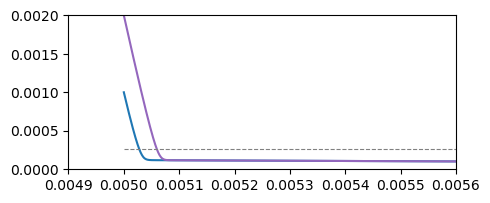

In [46]:
plt.plot(zl, vl)
# plt.plot(zl2, vl2, c='C3')
plt.plot(zl3, vl3, c='C4')
plt.plot(zl, ul, c='gray', ls='--', lw=0.8)
plt.axvline(1/Stb, c='C3',ls=':', lw=0.8)
plt.ylim(0, 2e-3)
plt.xlim(0.0049, 0.0056)